In [159]:
import pandas as pd
import nltk
from collections import Counter
import re

from nltk.corpus import stopwords
nltk.download("stopwords", quiet=True)
stopwords = stopwords.words("english")
stopwords.extend(["br", "ect", "hou", "com"])
import string
from sklearn.feature_extraction.text import CountVectorizer

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", font_scale=1.2)
plt.rcParams["figure.figsize"] = [10,8]
pd.set_option.display_max_columns = 0
pd.set_option.display_max_rows = 0

In [138]:
# read in data

epa_data = pd.read_csv('../data/epa_data.csv')

In [139]:
epa_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6734 entries, 0 to 6733
Data columns (total 10 columns):
EmailID                          6734 non-null object
Subject                          6516 non-null object
Message                          6734 non-null object
TaskSentence                     6734 non-null object
Judgements                       6734 non-null object
From.emailAddress.Name           6734 non-null object
From.emailAddress.ExternalId     0 non-null float64
From.emailAddress.Address        6734 non-null object
ToRecipients.emailAddressList    6734 non-null object
CcRecipients.emailAddressList    6734 non-null object
dtypes: float64(1), object(9)
memory usage: 526.2+ KB


In [140]:
epa_data.head(3)

,EmailID,Subject,Message,TaskSentence,Judgements,From.emailAddress.Name,From.emailAddress.ExternalId,From.emailAddress.Address,ToRecipients.emailAddressList,CcRecipients.emailAddressList
0,d7ZnSLcWHfdM9p97euzNkA==,Power DB Field Requirements,Chris - Attached is the spreadsheet shared wit...,Please forward back with any changes you might...,[{'1ed221006fdcbad8': ['chris.stokley@enron.co...,Fisher,NaN,steven.fisher@enron.com,"[{'emailAddress': {'Name': 'Stokley', 'Externa...",[]
1,l9qlLljWb7vV0Vz1P2/gWQ==,Re:,I agree with your proposal. <mark>Please comm...,Please communicate with Mark Holsworth.,[{'7dab55c4c50746f1': ['michelle.cash@enron.co...,Mark E Haedicke,NaN,mark.haedicke@enron.com,"[{'emailAddress': {'Name': 'Michelle Cash', 'E...",[]
2,L2HeC/lMpFK7xyVO7nxZsA==,Tony's deals,-Origin: LEWIS-A<br/>X-FileName: andy lewis 6-...,Andy - can you please forward this email to yo...,[{'7ba3b6a138bcadee': ['andrew.lewis@enron.com...,Richard Tomaski <Richard Tomaski/Corp/Enron@EN...,NaN,richard.tomaski@enron.com,"[{'emailAddress': {'Name': 'Andrew H Lewis', '...","[{'emailAddress': {'Name': 'Hunter S Shively',..."


In [176]:
# remove digits (https://stackoverflow.com/questions/43216530/adding-numbers-to-stop-words-to-scikit-learns-countvectorizer/45024512)

def no_number_preprocessor(tokens):
    # This alternative just replaces numbers with NUM token:
    # r = re.sub('(\d)+', 'NUM', tokens.lower())
    r = re.sub('(\d)+', '', tokens.lower())
    return r

In [177]:
# tokenize text

def ngrams(target, n=2):
    corpus = epa_data[target]
    count_vec = CountVectorizer(analyzer="word", stop_words=stopwords, ngram_range=(n, n), preprocessor=no_number_preprocessor).fit(corpus)
    bag_of_words = count_vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [178]:
# plot 2 sns barplots side by side

def plot_bars(x1, y1, x2, y2, num_ngrams=30):
    fig, ax = plt.subplots(1,2, figsize=(20,8))
    sns.barplot(x=y1, y=x1, orient='h', palette="Reds_d", ax=ax[0])
    sns.barplot(x=y2, y=x2, orient='h', palette="Blues_d", ax=ax[1])

    ax[0].set_title("Top " + str(num_ngrams) + " Task Words")
    ax[0].set_xlabel("Keyword Frequency")
    ax[1].set_title("Top " + str(num_ngrams) + " Email Words")
    ax[1].set_xlabel("Keyword Frequency")
    plt.tight_layout()
    plt.show()

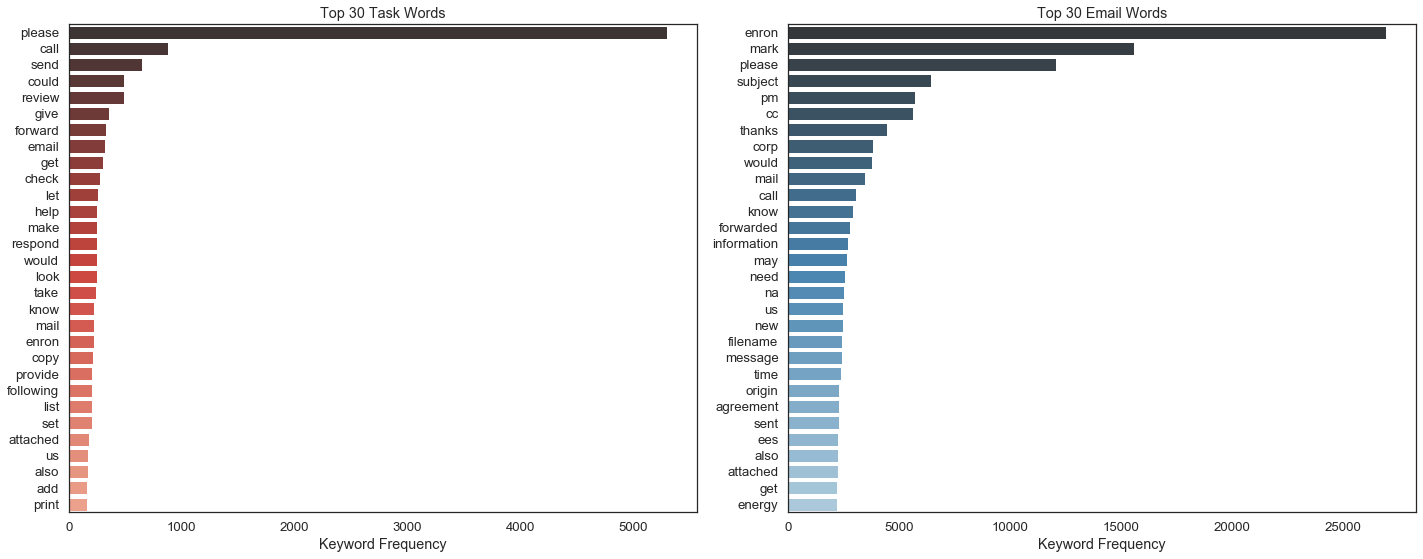

In [179]:
# word frequency

task_words = ngrams("TaskSentence", 1)[:30]
message_words = ngrams("Message", 1)[:30]

x_task, y_task = map(list, zip(*task_words))
x_message, y_message = map(list, zip(*message_words))

plot_bars(x_task, y_task, x_message, y_message)

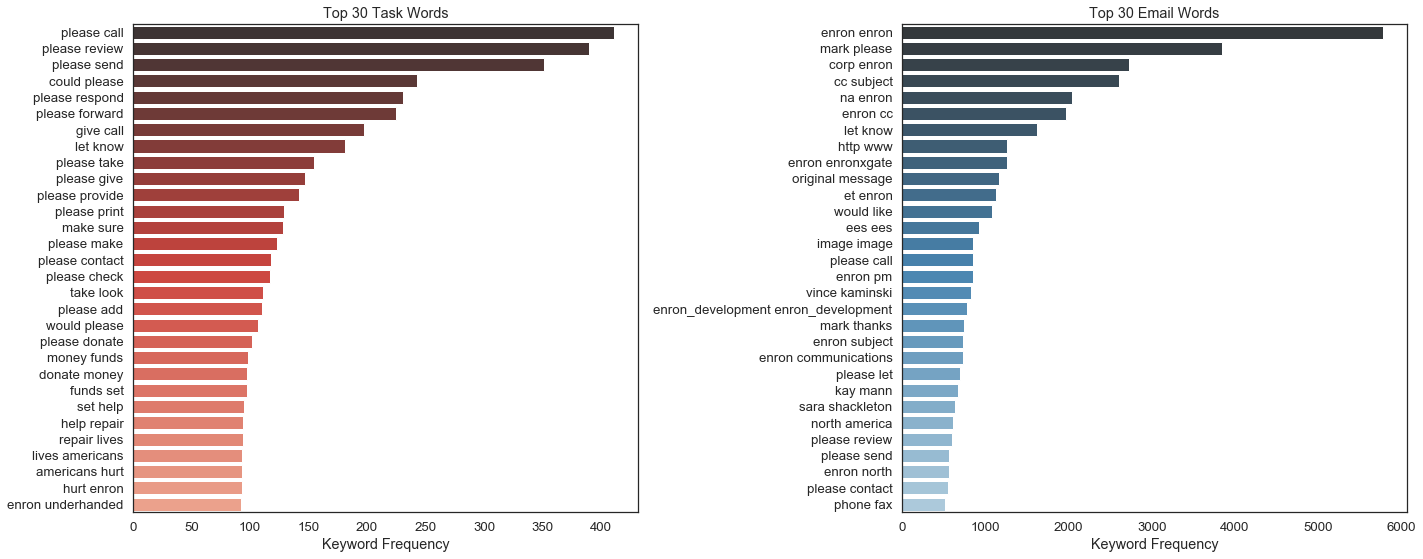

In [180]:
# bigram frequency

task_words_bigrams = ngrams("TaskSentence", 2)[:30]
message_words_bigrams = ngrams("Message", 2)[:30]

x_task_2, y_task_2 = map(list, zip(*task_words_bigrams))
x_message_2, y_message_2 = map(list, zip(*message_words_bigrams))

plot_bars(x_task_2, y_task_2, x_message_2, y_message_2)

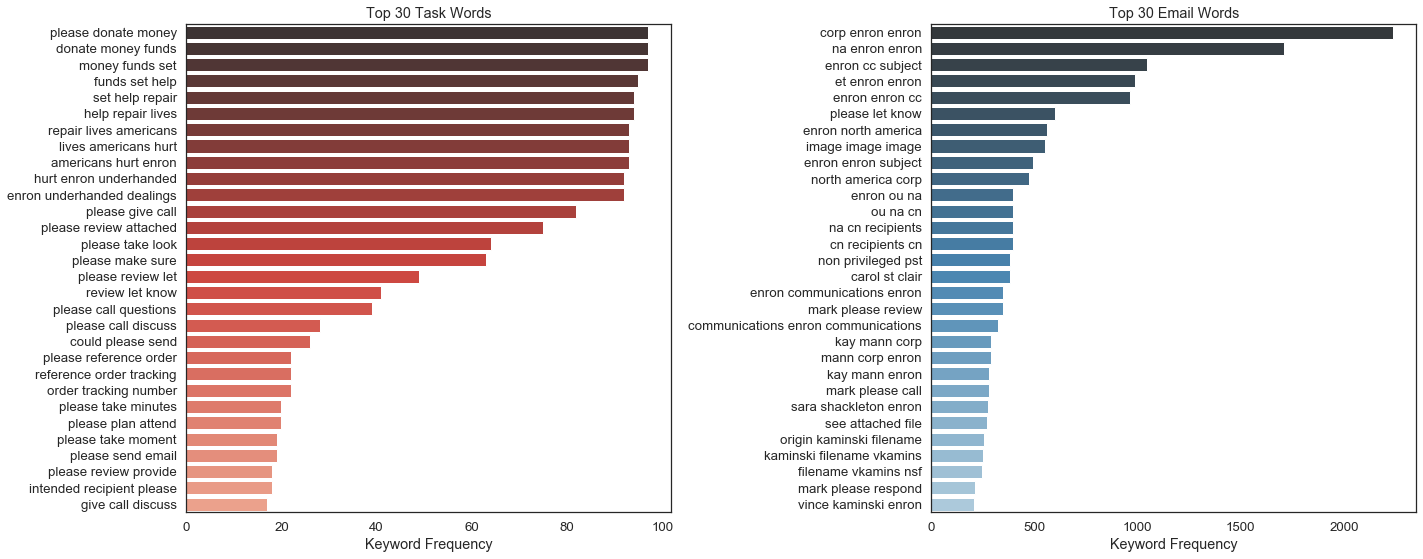

In [181]:
# trigram frequency

task_words_trigrams = ngrams("TaskSentence", 3)[:30]
message_words_trigrams = ngrams("Message", 3)[:30]

x_task_3, y_task_3 = map(list, zip(*task_words_trigrams))
x_message_3, y_message_3 = map(list, zip(*message_words_trigrams))

plot_bars(x_task_3, y_task_3, x_message_3, y_message_3)

In [182]:
# probability a word is from task or message

ngrams("Message", 1)

[('enron', 26959),
 ('mark', 15604),
 ('please', 12088),
 ('subject', 6443),
 ('pm', 5742),
 ('cc', 5618),
 ('thanks', 4461),
 ('corp', 3837),
 ('would', 3793),
 ('mail', 3473),
 ('call', 3063),
 ('know', 2926),
 ('forwarded', 2810),
 ('information', 2695),
 ('may', 2670),
 ('need', 2588),
 ('na', 2516),
 ('us', 2497),
 ('new', 2464),
 ('filename', 2438),
 ('message', 2424),
 ('time', 2401),
 ('origin', 2290),
 ('agreement', 2288),
 ('sent', 2278),
 ('ees', 2273),
 ('also', 2237),
 ('attached', 2230),
 ('get', 2225),
 ('energy', 2204),
 ('let', 2130),
 ('gas', 2096),
 ('http', 2035),
 ('deal', 1995),
 ('one', 1985),
 ('questions', 1969),
 ('nsf', 1947),
 ('email', 1935),
 ('send', 1927),
 ('john', 1879),
 ('company', 1878),
 ('like', 1852),
 ('enron_development', 1775),
 ('could', 1741),
 ('image', 1740),
 ('see', 1725),
 ('review', 1717),
 ('www', 1668),
 ('fax', 1634),
 ('meeting', 1599),
 ('vince', 1550),
 ('power', 1534),
 ('day', 1527),
 ('make', 1517),
 ('houston', 1478),
 ('orig

In [ ]:
for word in message vocab,


In [ ]:
# probability a word is in the summary given it is in the message



In [ ]:
# sentence order by per-word overlap with task


In [ ]:
# maybe something about sentence length and per-word overlap with task ?